In [1]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [2]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 50 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi
simulator = Aer.get_backend('qasm_simulator')
noise_model = create_noise_model(cz_fidelity=1)

shots_per_point = 50
reg = 3
n = 20
seed = 666
graph = nx.watts_strogatz_graph(n, reg, .5, seed=seed)
terms = {(i, j): np.random.rand() for i, j in graph.edges}
circ_ex = None

def weights(graph):
    rtn = {}
    for e in graph.edges:
        weight = graph.get_edge_data(e[0], e[1])['weight']
        rtn[e] = weight
    return rtn

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in terms.items()
        ]
            
        return sum(ens).real
#         samples = list(circ_ex.sample(shots_per_point))
#         values = []
#         for sample in samples:
#             value = 0
#             for k, v in terms.items():
#                 if sample[k[0]] != sample[k[1]]:
#                     value += 1
#             values.append(value)
#         return np.mean(values)
    return gamma_beta_objective, history



In [3]:
gammas = [1]
betas = [1]
p=1
# global circ_ex
# if circ_ex is None:
circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
# else:
#     new_circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
#     tm = new_circ_ex.to_dense_tn()
#     circ_ex.update_params_from(tm)
ZZ = qu.pauli('Z') & qu.pauli('Z')
ens = [
    circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
    for edge, weight in terms.items()
]

In [4]:
import networkx as nx
obj, hist = objective(graph)
all_data = []
bound = np.pi
samples = 10
for g in np.linspace(0, bound, num=samples):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

0.0
0.3490658503988659
0.6981317007977318
1.0471975511965976
1.3962634015954636
1.7453292519943295
2.0943951023931953
2.443460952792061
2.792526803190927
3.141592653589793


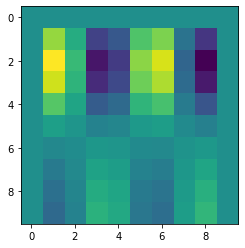

In [5]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))

In [10]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [11]:
from tqdm import tqdm
MAX_ITERATION = 100
fit_func1, history = objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [12]:
fit_func1, history = objective(graph)
fit_func1((np.array([.25  , .5])))

3.003673319775527

In [13]:
history, result = test_solver(oes)


  1%|          | 1/100 [00:01<02:38,  1.60s/it]

(array([0.4482019 , 0.17767144]), 1.586677768651694, 1.586677768651694, 0.39269908169872414)


  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

(array([0.25830098, 0.28261115]), 2.1030379412067184, 2.1030379412067184, 0.39269908169872414)


  3%|▎         | 3/100 [00:04<02:36,  1.61s/it]

(array([0.34521437, 0.38539526]), 3.0319625891054605, 3.0319625891054605, 0.39269908169872414)


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

(array([0.43929142, 0.51618017]), 3.554423154457572, 3.554423154457572, 0.39269908169872414)


  5%|▌         | 5/100 [00:08<02:34,  1.62s/it]

(array([0.35294851, 0.51262883]), 3.561566885669389, 3.561566885669389, 0.39269908169872414)


  6%|▌         | 6/100 [00:09<02:31,  1.61s/it]

(array([-0.42423363, -0.55383229]), 3.6785153575514693, 3.6785153575514693, 0.39269908169872414)


  7%|▋         | 7/100 [00:11<02:28,  1.60s/it]

(array([0.56263338, 0.40231125]), 2.468928955247719, 2.468928955247719, 0.39269908169872414)


  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]

(array([0.3796489 , 0.68738317]), 3.8133658006568316, 3.8133658006568316, 0.39269908169872414)


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

(array([0.15646875, 0.2794375 ]), 1.4210728326118707, 1.4210728326118707, 0.39269908169872414)


 10%|█         | 10/100 [00:16<02:24,  1.61s/it]

(array([-0.41792855, -0.72382928]), 3.776579615399375, 3.776579615399375, 0.39269908169872414)


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

(array([-1.15910011,  0.99256329]), 3.1094292798249232, 3.1094292798249232, 0.39269908169872414)


 12%|█▏        | 12/100 [00:19<02:24,  1.64s/it]

(array([-0.2864625 , -0.73757821]), 3.445665179274245, 3.445665179274245, 0.39269908169872414)


 13%|█▎        | 13/100 [00:21<02:24,  1.66s/it]

(array([-0.17380033, -0.56480535]), 2.3887994447615135, 2.3887994447615135, 0.39269908169872414)


 14%|█▍        | 14/100 [00:22<02:20,  1.64s/it]

(array([-0.32399856, -0.77634329]), 3.5884166681183256, 3.5884166681183256, 0.39269908169872414)


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

(array([-0.6110825 , -0.72669027]), 2.4357229576694484, 2.4357229576694484, 0.39269908169872414)


 16%|█▌        | 16/100 [00:26<02:18,  1.65s/it]

(array([-0.34384167, -0.30579642]), 2.558683622976627, 2.558683622976627, 0.39269908169872414)


 17%|█▋        | 17/100 [00:27<02:15,  1.63s/it]

(array([0.42330795, 0.49489847]), 3.526912746185715, 3.526912746185715, 0.39269908169872414)


 18%|█▊        | 18/100 [00:29<02:11,  1.61s/it]

(array([0.31768317, 0.53152777]), 3.4939982106362444, 3.4939982106362444, 0.39269908169872414)


 19%|█▉        | 19/100 [00:30<02:09,  1.60s/it]

(array([-0.30278005, -0.65136225]), 3.575365255996787, 3.575365255996787, 0.39269908169872414)


 20%|██        | 20/100 [00:32<02:09,  1.62s/it]

(array([-0.23751829, -0.7047873 ]), 3.0995538062825414, 3.0995538062825414, 0.39269908169872414)


 21%|██        | 21/100 [00:33<02:07,  1.61s/it]

(array([-0.08223257, -0.32508218]), 0.8833658591428774, 0.8833658591428774, 0.39269908169872414)


 22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]

(array([-0.08104355, -0.76619956]), 1.1926853243705173, 1.1926853243705173, 0.39269908169872414)


 23%|██▎       | 23/100 [00:37<02:02,  1.59s/it]

(array([0.15393904, 0.66680169]), 2.2074558469917407, 2.2074558469917407, 0.39269908169872414)


 24%|██▍       | 24/100 [00:38<02:02,  1.62s/it]

(array([-0.26035257, -0.79804687]), 3.1843214285962356, 3.1843214285962356, 0.39269908169872414)


 25%|██▌       | 25/100 [00:40<01:59,  1.60s/it]

(array([-0.09133586, -0.71463417]), 1.3589013170374011, 1.3589013170374011, 0.39269908169872414)


 26%|██▌       | 26/100 [00:41<01:57,  1.59s/it]

(array([-0.47468241, -0.19265021]), 1.6591844336709292, 1.6591844336709292, 0.39269908169872414)


 27%|██▋       | 27/100 [00:43<01:57,  1.62s/it]

(array([0.14517159, 0.57013418]), 2.051157937575298, 2.051157937575298, 0.39269908169872414)


 28%|██▊       | 28/100 [00:45<01:55,  1.60s/it]

(array([-0.40351678, -0.56537693]), 3.7269112757070753, 3.7269112757070753, 0.39269908169872414)


 29%|██▉       | 29/100 [00:46<01:53,  1.59s/it]

(array([0.36508452, 0.71053487]), 3.783373680339193, 3.783373680339193, 0.39269908169872414)


 30%|███       | 30/100 [00:48<01:51,  1.59s/it]

(array([-0.50630316, -0.43654998]), 2.995647542192937, 2.995647542192937, 0.39269908169872414)


 31%|███       | 31/100 [00:50<01:51,  1.62s/it]

(array([0.37085528, 0.35198141]), 2.888992197639565, 2.888992197639565, 0.39269908169872414)


 32%|███▏      | 32/100 [00:51<01:52,  1.65s/it]

(array([0.31657115, 0.5212583 ]), 3.463872474059224, 3.463872474059224, 0.39269908169872414)


 33%|███▎      | 33/100 [00:53<01:50,  1.64s/it]

(array([0.53981798, 0.30250264]), 2.151124737430538, 2.151124737430538, 0.39269908169872414)


 34%|███▍      | 34/100 [00:54<01:47,  1.63s/it]

(array([-0.36954834, -0.37946531]), 3.0426282484315488, 3.0426282484315488, 0.39269908169872414)


 35%|███▌      | 35/100 [00:56<01:46,  1.64s/it]

(array([-0.24891898, -0.31480468]), 2.238874907265479, 2.238874907265479, 0.39269908169872414)


 36%|███▌      | 36/100 [00:58<01:43,  1.62s/it]

(array([-0.24060828, -0.36264994]), 2.430663845091519, 2.430663845091519, 0.39269908169872414)


 37%|███▋      | 37/100 [00:59<01:41,  1.61s/it]

(array([-0.38589263, -0.67304285]), 3.8202369434221666, 3.8202369434221666, 0.39269908169872414)


 38%|███▊      | 38/100 [01:01<01:40,  1.63s/it]

(array([0.37552999, 0.55517899]), 3.70197453681497, 3.70197453681497, 0.39269908169872414)


 39%|███▉      | 39/100 [01:03<01:41,  1.67s/it]

(array([-0.29843102, -0.32725674]), 2.5553717910260683, 2.5553717910260683, 0.39269908169872414)


 40%|████      | 40/100 [01:04<01:40,  1.67s/it]

(array([0.29178847, 0.43097088]), 3.0435688471270956, 3.0435688471270956, 0.39269908169872414)


 41%|████      | 41/100 [01:06<01:36,  1.64s/it]

(array([0.39567318, 0.31449614]), 2.665887587547641, 2.665887587547641, 0.39269908169872414)


 42%|████▏     | 42/100 [01:08<01:35,  1.64s/it]

(array([0.44549467, 0.53717887]), 3.5895751261295077, 3.5895751261295077, 0.39269908169872414)


 43%|████▎     | 43/100 [01:09<01:33,  1.63s/it]

(array([0.21402591, 0.39406952]), 2.3661702941331257, 2.3661702941331257, 0.39269908169872414)


 44%|████▍     | 44/100 [01:11<01:31,  1.63s/it]

(array([-0.35750686, -0.74929622]), 3.730760500811635, 3.730760500811635, 0.39269908169872414)


 45%|████▌     | 45/100 [01:13<01:30,  1.65s/it]

(array([0.28863947, 0.6634993 ]), 3.495493384966646, 3.495493384966646, 0.39269908169872414)


 46%|████▌     | 46/100 [01:14<01:33,  1.72s/it]

(array([-0.27501221, -0.36788421]), 2.666385610280928, 2.666385610280928, 0.39269908169872414)


 47%|████▋     | 47/100 [01:16<01:32,  1.74s/it]

(array([-0.19518305, -0.4948692 ]), 2.50089646738581, 2.50089646738581, 0.39269908169872414)


 48%|████▊     | 48/100 [01:18<01:28,  1.70s/it]

(array([-0.24327757, -0.43578842]), 2.7532788049024233, 2.7532788049024233, 0.39269908169872414)


 49%|████▉     | 49/100 [01:20<01:26,  1.70s/it]

(array([-0.29011723, -1.12743486]), 2.3625595476242003, 2.3625595476242003, 0.39269908169872414)


 50%|█████     | 50/100 [01:21<01:23,  1.67s/it]

(array([-0.259462 , -0.3086473]), 2.263009645540591, 2.263009645540591, 0.39269908169872414)


 51%|█████     | 51/100 [01:23<01:22,  1.68s/it]

(array([-0.36457844, -0.56365577]), 3.703665795636061, 3.703665795636061, 0.39269908169872414)


 52%|█████▏    | 52/100 [01:25<01:21,  1.71s/it]

(array([0.2204747 , 0.55200138]), 2.8594352182805167, 2.8594352182805167, 0.39269908169872414)


 53%|█████▎    | 53/100 [01:26<01:21,  1.74s/it]

(array([0.26704954, 0.48604422]), 3.0886166766209087, 3.0886166766209087, 0.39269908169872414)


 54%|█████▍    | 54/100 [01:28<01:19,  1.73s/it]

(array([0.41542183, 0.33171462]), 2.765122445065099, 2.765122445065099, 0.39269908169872414)


 55%|█████▌    | 55/100 [01:30<01:15,  1.68s/it]

(array([0.19992013, 0.2184192 ]), 1.4077954240288422, 1.4077954240288422, 0.39269908169872414)


 56%|█████▌    | 56/100 [01:31<01:12,  1.65s/it]

(array([0.30794744, 0.25523083]), 2.12070590231136, 2.12070590231136, 0.39269908169872414)


 57%|█████▋    | 57/100 [01:33<01:11,  1.66s/it]

(array([-0.27233204, -0.3133765 ]), 2.3564625023100643, 2.3564625023100643, 0.39269908169872414)


 58%|█████▊    | 58/100 [01:35<01:09,  1.65s/it]

(array([-0.48855891, -0.2375112 ]), 1.9600708973556986, 1.9600708973556986, 0.39269908169872414)


 59%|█████▉    | 59/100 [01:36<01:06,  1.62s/it]

(array([0.39988871, 0.37234486]), 3.0154682046240375, 3.0154682046240375, 0.39269908169872414)


 60%|██████    | 60/100 [01:38<01:05,  1.63s/it]

(array([-0.3514383 , -0.17260333]), 1.5618962808138697, 1.5618962808138697, 0.39269908169872414)


 61%|██████    | 61/100 [01:39<01:03,  1.62s/it]

(array([0.17522562, 0.5199132 ]), 2.339270928793172, 2.339270928793172, 0.39269908169872414)


 62%|██████▏   | 62/100 [01:41<01:01,  1.61s/it]

(array([0.13857022, 0.41666861]), 1.707478198785545, 1.707478198785545, 0.39269908169872414)


 63%|██████▎   | 63/100 [01:43<00:59,  1.60s/it]

(array([0.20738172, 0.4043371 ]), 2.348968888244151, 2.348968888244151, 0.39269908169872414)


 64%|██████▍   | 64/100 [01:44<00:58,  1.63s/it]

(array([0.61096526, 0.61568632]), 2.4407751444310857, 2.4407751444310857, 0.39269908169872414)


 65%|██████▌   | 65/100 [01:46<00:56,  1.62s/it]

(array([-0.4916247 , -0.51748975]), 3.340896079782512, 3.340896079782512, 0.39269908169872414)


 66%|██████▌   | 66/100 [01:47<00:54,  1.60s/it]

(array([0.40011219, 0.62720263]), 3.806490013413485, 3.806490013413485, 0.39269908169872414)


 67%|██████▋   | 67/100 [01:49<00:52,  1.60s/it]

(array([-0.25152155, -0.78364779]), 3.1389602613929264, 3.1389602613929264, 0.39269908169872414)


 68%|██████▊   | 68/100 [01:51<00:52,  1.63s/it]

(array([-0.12415932, -0.24233006]), 1.0247676292640708, 1.0247676292640708, 0.39269908169872414)


 69%|██████▉   | 69/100 [01:52<00:50,  1.63s/it]

(array([0.36516493, 0.2447172 ]), 2.1559028423894335, 2.1559028423894335, 0.39269908169872414)


 70%|███████   | 70/100 [01:54<00:48,  1.63s/it]

(array([0.50285745, 0.36797868]), 2.7065140471227416, 2.7065140471227416, 0.39269908169872414)


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

(array([-0.36075345, -1.09170077]), 2.704257436277701, 2.704257436277701, 0.39269908169872414)


 72%|███████▏  | 72/100 [01:57<00:46,  1.65s/it]

(array([0.1060317, 0.6872876]), 1.571449365012198, 1.571449365012198, 0.39269908169872414)


 73%|███████▎  | 73/100 [01:59<00:43,  1.63s/it]

(array([0.25530001, 0.28940154]), 2.128543351376132, 2.128543351376132, 0.39269908169872414)


 74%|███████▍  | 74/100 [02:01<00:42,  1.65s/it]

(array([ 0.95361031, -0.88873018]), 2.1603577248407317, 2.1603577248407317, 0.39269908169872414)


 75%|███████▌  | 75/100 [02:02<00:41,  1.68s/it]

(array([0.22419129, 0.64825335]), 2.983725408953291, 2.983725408953291, 0.39269908169872414)


 76%|███████▌  | 76/100 [02:04<00:39,  1.66s/it]

(array([-0.10482727, -0.59822489]), 1.5391468243142894, 1.5391468243142894, 0.39269908169872414)


 77%|███████▋  | 77/100 [02:06<00:38,  1.67s/it]

(array([0.45978656, 0.52882217]), 3.519978818962261, 3.519978818962261, 0.39269908169872414)


 78%|███████▊  | 78/100 [02:07<00:36,  1.65s/it]

(array([0.37479115, 0.23839471]), 2.114955181374932, 2.114955181374932, 0.39269908169872414)


 79%|███████▉  | 79/100 [02:09<00:35,  1.68s/it]

(array([0.25067068, 0.64750882]), 3.2187806633920273, 3.2187806633920273, 0.39269908169872414)


 80%|████████  | 80/100 [02:11<00:33,  1.67s/it]

(array([-0.35446087, -0.42404805]), 3.2400833237787197, 3.2400833237787197, 0.39269908169872414)


 81%|████████  | 81/100 [02:12<00:31,  1.67s/it]

(array([-0.20588435, -0.60129793]), 2.7758764891602423, 2.7758764891602423, 0.39269908169872414)


 82%|████████▏ | 82/100 [02:14<00:29,  1.66s/it]

(array([0.37990201, 0.36416026]), 2.966840340626523, 2.966840340626523, 0.39269908169872414)


 83%|████████▎ | 83/100 [02:16<00:28,  1.67s/it]

(array([0.66453024, 0.68773842]), 1.7750276142305432, 1.7750276142305432, 0.39269908169872414)


 84%|████████▍ | 84/100 [02:17<00:27,  1.69s/it]

(array([0.50494416, 0.22888759]), 1.8433955140377687, 1.8433955140377687, 0.39269908169872414)


 85%|████████▌ | 85/100 [02:19<00:25,  1.73s/it]

(array([-0.40553712, -0.45038392]), 3.3875585076519674, 3.3875585076519674, 0.39269908169872414)


 86%|████████▌ | 86/100 [02:21<00:24,  1.77s/it]

(array([0.32182699, 0.30360513]), 2.4900711509299636, 2.4900711509299636, 0.39269908169872414)


 87%|████████▋ | 87/100 [02:23<00:22,  1.75s/it]

(array([0.34926186, 0.36087635]), 2.907492608748511, 2.907492608748511, 0.39269908169872414)


 88%|████████▊ | 88/100 [02:24<00:20,  1.74s/it]

(array([0.17730227, 0.26097715]), 1.4923277358112614, 1.4923277358112614, 0.39269908169872414)


 89%|████████▉ | 89/100 [02:26<00:19,  1.74s/it]

(array([0.23520996, 0.51035083]), 2.9094192658071782, 2.9094192658071782, 0.39269908169872414)


 90%|█████████ | 90/100 [02:28<00:17,  1.77s/it]

(array([-0.37545316, -0.32448383]), 2.724299421250859, 2.724299421250859, 0.39269908169872414)


 91%|█████████ | 91/100 [02:30<00:15,  1.75s/it]

(array([-0.32033898, -0.47108981]), 3.327532127376133, 3.327532127376133, 0.39269908169872414)


 92%|█████████▏| 92/100 [02:31<00:13,  1.73s/it]

(array([0.31785021, 0.2238743 ]), 1.9173120123876517, 1.9173120123876517, 0.39269908169872414)


 93%|█████████▎| 93/100 [02:33<00:11,  1.71s/it]

(array([-1.14947483,  0.38226188]), 3.05068010089103, 3.05068010089103, 0.39269908169872414)


 94%|█████████▍| 94/100 [02:35<00:10,  1.78s/it]

(array([-0.37300326, -0.51147698]), 3.592596072466081, 3.592596072466081, 0.39269908169872414)


 95%|█████████▌| 95/100 [02:37<00:08,  1.79s/it]

(array([0.30780203, 0.6169484 ]), 3.5830893580543917, 3.5830893580543917, 0.39269908169872414)


 96%|█████████▌| 96/100 [02:39<00:06,  1.74s/it]

(array([-0.16019886, -0.53180583]), 2.1869394716677886, 2.1869394716677886, 0.39269908169872414)


 97%|█████████▋| 97/100 [02:40<00:05,  1.74s/it]

(array([0.36543538, 0.45331917]), 3.3836464563664657, 3.3836464563664657, 0.39269908169872414)


 98%|█████████▊| 98/100 [02:42<00:03,  1.75s/it]

(array([-0.34576015, -0.50366351]), 3.5178243533519407, 3.5178243533519407, 0.39269908169872414)


 99%|█████████▉| 99/100 [02:44<00:01,  1.70s/it]

(array([-0.43418777, -0.37720761]), 3.0016408004092674, 3.0016408004092674, 0.39269908169872414)


100%|██████████| 100/100 [02:45<00:00,  1.66s/it]

(array([-0.2237747 , -0.15347987]), 1.1064704129310245, 1.1064704129310245, 0.39269908169872414)
fitness at iteration 100 1.1064704129310245
local optimum discovered by solver:
 [-0.2237747  -0.15347987]
fitness score at this local optimum: 1.1064704129310245


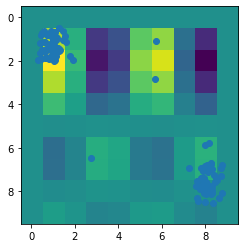

In [17]:
plt.imshow(all_data)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [el[1]%(bound)*(samples-1)/(bound) for el in xys]
plt.scatter(x, y)

In [29]:
[h[0] for h in history]

[array([0.4482019 , 0.17767144]),
 array([0.25830098, 0.28261115]),
 array([0.34521437, 0.38539526]),
 array([0.43929142, 0.51618017]),
 array([0.35294851, 0.51262883]),
 array([-0.42423362, -0.55383229]),
 array([0.56263338, 0.40231125]),
 array([0.3796489 , 0.68738317]),
 array([0.15646875, 0.2794375 ]),
 array([-0.41792855, -0.72382928]),
 array([-1.15910011,  0.99256329]),
 array([-0.2864625 , -0.73757821]),
 array([-0.17380033, -0.56480535]),
 array([-0.32399856, -0.77634329]),
 array([-0.6110825 , -0.72669027]),
 array([-0.34384167, -0.30579642]),
 array([0.42330795, 0.49489847]),
 array([0.31768317, 0.53152777]),
 array([-0.30278005, -0.65136225]),
 array([-0.23751829, -0.7047873 ]),
 array([-0.08223257, -0.32508218]),
 array([-0.08104355, -0.76619956]),
 array([0.15393904, 0.66680169]),
 array([-0.26035257, -0.79804687]),
 array([-0.19642185, -0.20633501]),
 array([-0.4746824 , -0.19265021]),
 array([0.14517159, 0.57013418]),
 array([-0.40351677, -0.56537693]),
 array([0.365084

In [ ]:
# It's currently reporting the average fitness, which of course it might want to use when it's estimating the energy
# But at the end it should report the maximum value. Here the mean is 10.1, which suggests that a better bitstring was 
# sampled.

# Compute Maxcut of Graphs

In [18]:
from tqdm import tqdm
annealing_attempts = []
shots_per_point = 10
func, history2 = objective(graph)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=10,
    initial_temp=100,
    maxfun=one_hour*reprate,
    restart_temp_ratio=1E-10,
    no_local_search=True)
result.fun = -result.fun
(result.x, result.fun)        

(array([5.06366241, 0.67649936]), 4.898229484250009)

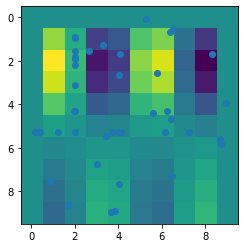

In [19]:
plt.scatter([(h[0][0]%(np.pi/2))*9/(np.pi/2) for h in history2], [(h[0][1]%(np.pi/2))*10/(np.pi/2) for h in history2])
plt.imshow(all_data)

In [ ]:
shots_per_points = [1, 10, 100, 1000]
maxiters = [1, 10, 100, 1000]
initial_temp = [1, 10, 100, 1000]
restart_temp_ratio = [1E-10, 1E-9, 1E-8, 1E-7]